# Proyek Klasifikasi Gambar: 10 Jenis Hewan (Dataset Animals-10)

- Nama: Bimoseno Kuma
- Email: kuma24@student.ub.ac.id
- ID Dicoding: kukuma

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install split-folders --quiet
!pip install tensorflowjs --quiet
from google.colab import files, drive
import os
import sys
import shutil
import zipfile
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
import subprocess
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import splitfolders
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.34.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
Mounted at /content/drive


In [2]:
print("Silakan upload file kaggle.json Anda:")
files.upload()

# Membuat direktori .kaggle dan memindahkan file kaggle.json ke sana
!mkdir -p /root/.kaggle
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

print("\nFile kaggle.json berhasil dikonfigurasi.")

Silakan upload file kaggle.json Anda:


Saving kaggle.json to kaggle.json

File kaggle.json berhasil dikonfigurasi.


### Data Loading

In [3]:
# Direktori dataset akan dibuat di /content/
dataset_dir = '/content/raw-img'

if os.path.exists(dataset_dir):
    print("Dataset 'raw-img' sudah ada. Melewatkan proses unduh.")
else:
    print("Dataset belum ada. Memulai proses unduh dari Kaggle...")
    # Perintah kaggle untuk mengunduh dan unzip langsung ke direktori kerja saat ini (/content/)
    !kaggle datasets download -d alessiocorrado99/animals10 --unzip
    print("\nDataset berhasil diunduh dan diekstrak.")

# Verifikasi isi folder
print("\nIsi direktori kerja saat ini (/content/):")
!ls -lh

Dataset belum ada. Memulai proses unduh dari Kaggle...
Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0
100% 585M/586M [00:04<00:00, 207MB/s]
100% 586M/586M [00:04<00:00, 127MB/s]

Dataset berhasil diunduh dan diekstrak.

Isi direktori kerja saat ini (/content/):
total 16K
drwx------  6 root root 4.0K Jun 26 11:36 drive
drwxr-xr-x 12 root root 4.0K Jun 26 11:36 raw-img
drwxr-xr-x  1 root root 4.0K Jun 24 13:38 sample_data
-rw-r--r--  1 root root  380 Jun 26 11:36 translate.py


### Data Preprocessing

#### Split Dataset

In [4]:
# Path input dan output
input_folder = '/content/raw-img'
output_folder = '/content/dataset_split'

# Check if input folder exists
if not os.path.exists(input_folder):
    print(f"Error: Folder '{input_folder}' tidak ditemukan!")
    print("Pastikan dataset sudah didownload dan diekstrak.")
    sys.exit(1)

# Hapus folder output jika sudah ada untuk memastikan kebersihan
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)
    print(f"Removed existing {output_folder}")

# Lakukan pembagian dengan rasio 80:10:10
print("\nSplitting dataset into train/val/test...")
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.8, .1, .1))

print(f"Dataset berhasil dibagi ke dalam folder: {output_folder}")
print(f"Isi folder output: {os.listdir(output_folder)}")


Splitting dataset into train/val/test...


Copying files: 26179 files [00:05, 4920.66 files/s]

Dataset berhasil dibagi ke dalam folder: /content/dataset_split
Isi folder output: ['train', 'test', 'val']


In [5]:
# --- Membangun Pipeline tf.data yang Efisien ---
BATCH_SIZE = 32
IMG_WIDTH, IMG_HEIGHT = 150, 150
AUTOTUNE = tf.data.AUTOTUNE

# Konversi path ke objek Pathlib untuk kemudahan
data_dir = pathlib.Path(output_folder)
train_dir = data_dir / 'train'
val_dir = data_dir / 'val'
test_dir = data_dir / 'test'

# Buat dataset dari direktori
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    shuffle=False,
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    shuffle=False,
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
)

# Dapatkan nama kelas
class_names = train_dataset.class_names
print("\nNama kelas yang ditemukan:", class_names)

# Optimalkan dataset dengan cache dan prefetch
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

print("\n✓ Data pipeline sederhana (tanpa normalisasi/augmentasi) telah dibuat.")

Found 20938 files belonging to 10 classes.
Found 2614 files belonging to 10 classes.
Found 2627 files belonging to 10 classes.

Nama kelas yang ditemukan: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']

✓ Data pipeline sederhana (tanpa normalisasi/augmentasi) telah dibuat.


## Modelling

In [6]:
device = '/GPU:0' if len(tf.config.list_physical_devices('GPU')) > 0 else '/CPU:0'
print(f"Using device: {device}")

with tf.device(device):
    # Definisikan input layer
    input_layer = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))

    # 1. Buat lapisan augmentasi
    data_augmentation = tf.keras.Sequential(
        [
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.2),
            tf.keras.layers.RandomZoom(0.2),
        ],
        name="augmentation"
    )
    # Terapkan augmentasi pada input
    x = data_augmentation(input_layer)

    # 2. Muat base model.
    base_model = EfficientNetB0(weights='imagenet', include_top=False)
    base_model.trainable = False

    # 3. Sambungkan alur model
    x = base_model(x, training=False)

    # 4. Tambahkan classifier head
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(len(class_names), activation='softmax')(x)

    # 5. Buat model akhir untuk training (dengan augmentasi)
    model = Model(inputs=input_layer, outputs=output_layer, name="model_with_augmentation")

    # 6. Kompilasi model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

print("\nModel Summary (Transfer Learning with Augmentation - Final Corrected):")
model.summary()

# --- Create a separate model for conversion and inference (without augmentation) ---
print("\nCreating a separate model without augmentation for conversion and inference...")
with tf.device(device):
    # Define input layer for the new model
    inference_input_layer = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))

    # Connect base model directly to the input
    y = base_model(inference_input_layer, training=False)

    # Add classifier head
    y = GlobalAveragePooling2D()(y)
    y = Dense(512, activation='relu')(y)
    y = Dropout(0.5)(y)
    inference_output_layer = Dense(len(class_names), activation='softmax')(y)

    # Create the model without augmentation
    model_no_augmentation = Model(inputs=inference_input_layer, outputs=inference_output_layer, name="model_no_augmentation")

# Transfer weights from the trained model's non-augmentation layers
for layer in model_no_augmentation.layers:
    if layer.name in [l.name for l in base_model.layers] or layer.name in ["dense", "dropout", "dense_1", "global_average_pooling2d"]:
         if model.get_layer(layer.name).get_weights():
             layer.set_weights(model.get_layer(layer.name).get_weights())


print("\nModel Summary (For Conversion and Inference - No Augmentation):")
model_no_augmentation.summary()

Using device: /GPU:0
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

Model Summary (Transfer Learning with Augmentation - Final Corrected):


Model: "model_with_augmentation"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,710,573 (17.97 MB)

 Trainable params: 661,002 (2.52 MB)

 Non-trainable params: 4,049,571 (15.45 MB)


Creating a separate model without augmentation for conversion and inference...

Model Summary (For Conversion and Inference - No Augmentation):


Model: "model_no_augmentation"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,710,573 (17.97 MB)

 Trainable params: 661,002 (2.52 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

## Evaluasi dan Visualisasi

In [7]:
# Definisikan callbacks
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

In [8]:
# Tentukan jumlah epoch
EPOCHS = 50

print(f"\nStarting training for {EPOCHS} epochs...")

# Latih model menggunakan tf.data.Dataset
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks=callbacks,
    verbose=1
)



Starting training for 50 epochs...
Epoch 1/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6361 - loss: 1.2216
Epoch 1: val_accuracy improved from -inf to 0.94070, saving model to best_model.keras
655/655 ━━━━━━━━━━━━━━━━━━━━ 59s 65ms/step - accuracy: 0.6363 - loss: 1.2209 - val_accuracy: 0.9407 - val_loss: 0.2494 - learning_rate: 1.0000e-04
Epoch 2/50
653/655 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8597 - loss: 0.4519
Epoch 2: val_accuracy improved from 0.94070 to 0.94606, saving model to best_model.keras
655/655 ━━━━━━━━━━━━━━━━━━━━ 28s 43ms/step - accuracy: 0.8597 - loss: 0.4518 - val_accuracy: 0.9461 - val_loss: 0.1939 - learning_rate: 1.0000e-04
Epoch 3/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8792 - loss: 0.3708
Epoch 3: val_accuracy improved from 0.94606 to 0.94912, saving model to best_model.keras
655/655 ━━━━━━━━━━━━━━━━━━━━ 26s 40ms/step - accuracy: 0.8792 - loss: 0.3708 - val_accuracy: 0.9491 - val_loss: 0.1740 - learning_rate: 1.0000e-0


Plotting training history...


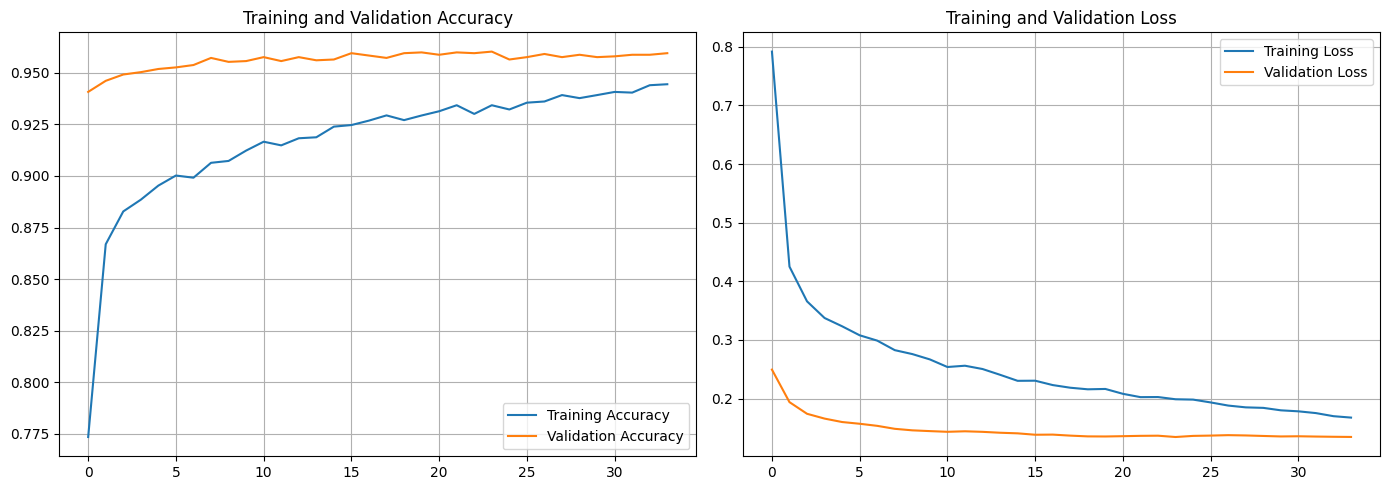

In [9]:
# Plot akurasi dan loss
print("\nPlotting training history...")
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid(True)
plt.tight_layout()
plt.show()


Mengevaluasi model pada data tes...
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.9689 - loss: 0.1193

Akurasi pada data tes: 96.42%
Loss pada data tes: 0.1402

Generating predictions...
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step

Classification Report:
              precision    recall  f1-score   support

        cane       0.96      0.97      0.96       487
     cavallo       0.97      0.97      0.97       263
    elefante       0.98      0.99      0.98       146
    farfalla       0.99      0.98      0.98       212
     gallina       0.97      0.97      0.97       311
       gatto       0.95      0.95      0.95       168
       mucca       0.90      0.94      0.92       188
      pecora       0.91      0.91      0.91       182
       ragno       0.99      0.98      0.99       483
  scoiattolo       0.97      0.97      0.97       187

    accuracy                           0.96      2627
   macro avg       0.96      0.96      0.96      2627
weighted avg       0.96      0.96   

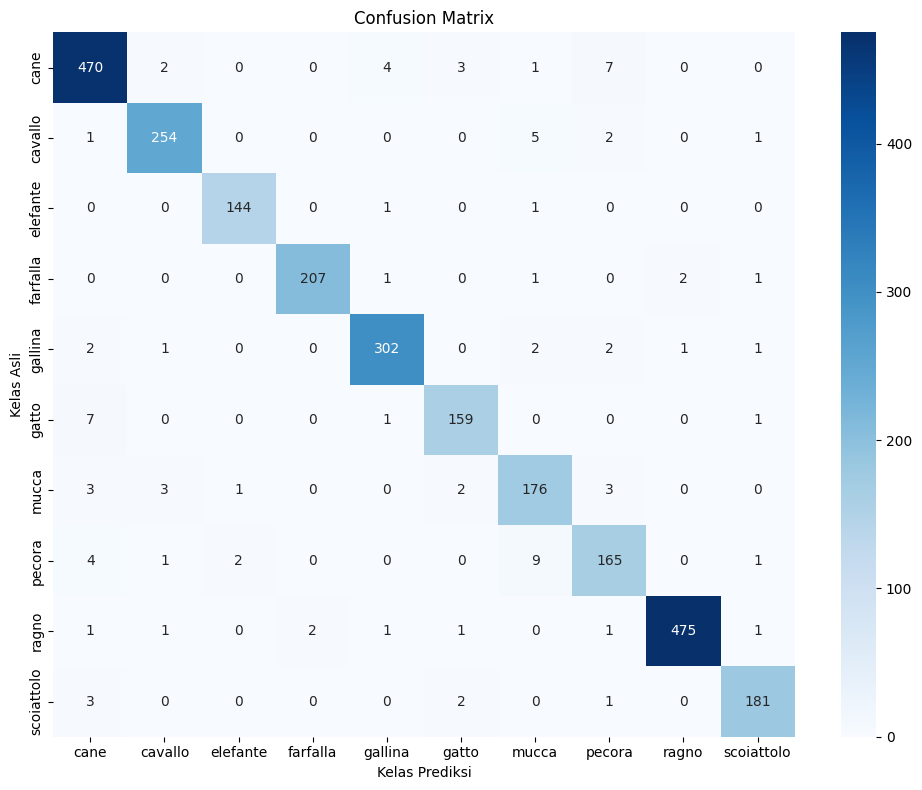

In [10]:
# --- Evaluasi pada data tes menggunakan test_dataset ---
print("\nMengevaluasi model pada data tes...")
test_loss, test_acc = model.evaluate(test_dataset, verbose=1)

print(f'\nAkurasi pada data tes: {test_acc*100:.2f}%')
print(f'Loss pada data tes: {test_loss:.4f}')

# --- Prediksi untuk classification report dan confusion matrix ---
print("\nGenerating predictions...")
Y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(Y_pred, axis=1)

y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Laporan Klasifikasi
print('\nClassification Report:')
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Kelas Asli')
plt.xlabel('Kelas Prediksi')
plt.tight_layout()
plt.show()


## Konversi Model

In [12]:
# --- Langkah 1: Muat model terlatih Anda (yang masih memiliki lapisan augmentasi) ---
print("Memuat model terlatih dari 'best_model.keras'...")
try:
    # Ini adalah model lengkap yang Anda gunakan untuk training
    trained_model = tf.keras.models.load_model('best_model.keras')
    print("✓ Model terlatih berhasil dimuat.")
except Exception as e:
    print(f"❌ GAGAL memuat 'best_model.keras': {e}")
    # Hentikan proses jika model tidak bisa dimuat
    sys.exit(1) # Use sys.exit(1) to stop execution on error

# --- Langkah 2: Transfer bobot dari model terlatih ke model inferensi (tanpa augmentasi) ---
print("\nMentransfer bobot ke model inferensi (tanpa augmentasi)...")

# Assuming model_no_augmentation was defined in a previous cell and is accessible
if 'model_no_augmentation' not in locals():
    print("Error: 'model_no_augmentation' not found. Please ensure the cell defining it has been run.")
    sys.exit(1)

# Iterate through layers of model_no_augmentation and set weights from trained_model
for layer_no_aug in model_no_augmentation.layers:
    # Find the corresponding layer in the trained_model, skipping the augmentation layer
    try:
        # Check if the layer name exists in the trained model and is not the augmentation layer
        if layer_no_aug.name != "augmentation" and trained_model.get_layer(layer_no_aug.name) is not None:
             # Only transfer weights if the layer in trained_model has weights
             if trained_model.get_layer(layer_no_aug.name).get_weights():
                 layer_no_aug.set_weights(trained_model.get_layer(layer_no_aug.name).get_weights())
                 print(f"  ✓ Bobot ditransfer untuk lapisan: {layer_no_aug.name}")
             else:
                 print(f"  - Lapisan '{layer_no_aug.name}' di trained_model tidak memiliki bobot untuk ditransfer.")
        elif layer_no_aug.name == "augmentation":
             print(f"  - Melewatkan lapisan augmentasi: {layer_no_aug.name}")
        else:
             print(f"  - Lapisan '{layer_no_aug.name}' di model_no_augmentation tidak ditemukan di trained_model.")

    except ValueError:
        # Handle cases where the layer name might not exist in trained_model
        print(f"  - Lapisan '{layer_no_aug.name}' di model_no_augmentation tidak ditemukan di trained_model.")
    except Exception as e:
        print(f"  ❌ Gagal mentransfer bobot untuk lapisan '{layer_no_aug.name}': {e}")


print("✓ Transfer bobot selesai.")


# --- Langkah 3: Ekspor 'model_no_augmentation' ke dalam format yang dibutuhkan ---

# Pastikan direktori ada dan sesuai kriteria submission
os.makedirs('saved_model', exist_ok=True)
os.makedirs('tflite', exist_ok=True)
os.makedirs('tfjs_model', exist_ok=True)

# Definisikan path yang BENAR untuk submission
SAVED_MODEL_PATH = 'saved_model' # Cukup nama foldernya
TFLITE_DIR = 'tflite'
TFJS_MODEL_PATH = 'tfjs_model'


# 1. Ekspor ke format SavedModel
print(f"\nMengekspor model inferensi ke '{SAVED_MODEL_PATH}'...")
# PENTING: Gunakan model inferensi yang sudah diberi bobot
try:
    model_no_augmentation.export(SAVED_MODEL_PATH)
    print("✓ Model SavedModel berhasil diekspor.")
except Exception as e:
    print(f"❌ GAGAL mengekspor SavedModel: {e}")
    sys.exit(1)


# 2. Konversi ke format TF-Lite dan buat label.txt
print("\nMemulai konversi ke format TensorFlow Lite...")
try:
    converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_PATH)
    tflite_model = converter.convert()
    tflite_model_path = os.path.join(TFLITE_DIR, 'model.tflite')
    with open(tflite_model_path, 'wb') as f:
        f.write(tflite_model)
    print(f"✓ Model TF-Lite berhasil disimpan di: {tflite_model_path}")

    # Membuat label.txt
    label_path = os.path.join(TFLITE_DIR, 'label.txt')
    with open(label_path, 'w') as f:
        for class_name in class_names:
            f.write(f"{class_name}\n")
    print(f"✓ File label.txt berhasil dibuat di: {label_path}")

except Exception as e:
    print(f"❌ GAGAL mengonversi ke TF-Lite atau membuat label.txt: {e}")
    sys.exit(1)


# 3. Konversi ke format TFJS
print("\nMemulai konversi ke format TensorFlow.js...")
try:
    # Install tensorflowjs jika belum ada
    !pip install tensorflowjs --quiet
    # Konversi dari format SavedModel
    # Use the correct input path for the converter
    !tensorflowjs_converter --input_format=tf_saved_model {SAVED_MODEL_PATH} {TFJS_MODEL_PATH}
    print(f"\n✓ Proses konversi TFJS selesai. Periksa folder '{TFJS_MODEL_PATH}'.")
    !ls -lh {TFJS_MODEL_PATH}
except Exception as e:
    print(f"❌ GAGAL mengonversi ke TensorFlow.js: {e}")
    sys.exit(1)

Memuat model terlatih dari 'best_model.keras'...
✓ Model terlatih berhasil dimuat.

Mentransfer bobot ke model inferensi (tanpa augmentasi)...
  - Lapisan 'input_layer_3' di model_no_augmentation tidak ditemukan di trained_model.
  ✓ Bobot ditransfer untuk lapisan: efficientnetb0
  - Lapisan 'global_average_pooling2d_1' di model_no_augmentation tidak ditemukan di trained_model.
  - Lapisan 'dense_2' di model_no_augmentation tidak ditemukan di trained_model.
  - Lapisan 'dropout_1' di model_no_augmentation tidak ditemukan di trained_model.
  - Lapisan 'dense_3' di model_no_augmentation tidak ditemukan di trained_model.
✓ Transfer bobot selesai.

Mengekspor model inferensi ke 'saved_model'...
Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_485')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  13788199766708

## Inference (Optional)

In [14]:
print("\nPerforming inference test...")

# The previous error indicated that load_model() in Keras 3 cannot load SavedModel format directly.
# Use tf.keras.layers.TFSMLayer to load the SavedModel for inference.
# Use the correct path for the SavedModel without augmentation
# The SavedModel is exported to the 'saved_model' directory.
SAVED_MODEL_PATH_FOR_INFERENCE = 'saved_model'

try:
    # Load the SavedModel as a TFSMLayer using the model without augmentation
    # Removed the input_shape argument as it's not supported by TFSMLayer in this version
    loaded_model_layer = tf.keras.layers.TFSMLayer(SAVED_MODEL_PATH_FOR_INFERENCE, call_endpoint='serving_default')

    # To use this layer for predictions, we need a simple wrapper model
    # Define the input layer matching the expected input shape (inferred from the SavedModel)
    # We can get the input shape from the loaded layer's input spec if needed,
    # but for a simple wrapper, we can often let it be dynamic (None) or match the training input shape.
    # Let's use the training input shape for clarity in the wrapper model.
    inference_input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))

    # Pass the input through the loaded SavedModel layer
    inference_output = loaded_model_layer(inference_input)

    # Create a new model for inference
    loaded_model = Model(inputs=inference_input, outputs=inference_output)

    print("✓ SavedModel (no augmentation) loaded as TFSMLayer successfully for inference.")

except Exception as e:
    print(f"Error loading SavedModel (no augmentation) as TFSMLayer: {e}")
    sys.exit("Failed to load the SavedModel for inference.")

# Fungsi untuk memuat dan memproses gambar
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalisasi
    return img_array

# Pilih kelas acak dan gambar acak dari data tes
random_class = random.choice(class_names)
random_class_path = os.path.join(test_dir, random_class)
random_image_name = random.choice(os.listdir(random_class_path))
test_image_path = os.path.join(random_class_path, random_image_name)

print(f"Testing inference on a random image from class: '{random_class}'")
print(f"Image path: {test_image_path}")

# Process image and make prediction using the loaded model
processed_img = load_and_preprocess_image(test_image_path)
prediction_output = loaded_model.predict(processed_img)

# The output of TFSMLayer is a dictionary. Access the prediction tensor.
# The key is typically 'output_0' for a single output model.
if isinstance(prediction_output, dict) and 'output_0' in prediction_output:
    prediction = prediction_output['output_0']
elif isinstance(prediction_output, tf.Tensor):
     prediction = prediction_output
else:
    print(f"Unexpected prediction output format: {type(prediction_output)}")
    print(f"Output keys: {prediction_output.keys() if isinstance(prediction_output, dict) else 'N/A'}")
    sys.exit("Could not extract prediction tensor from model output.")


predicted_class_index = np.argmax(prediction)
predicted_class_name = class_names[predicted_class_index]
confidence = np.max(prediction) * 100

print(f"\nPrediction:")
print(f"  Predicted class: {predicted_class_name}")
print(f"  Confidence: {confidence:.2f}%")
print(f"  Actual class: {random_class}")


Performing inference test...
✓ SavedModel (no augmentation) loaded as TFSMLayer successfully for inference.
Testing inference on a random image from class: 'cavallo'
Image path: /content/dataset_split/test/cavallo/OIP-Il01X1P2aW2iI9cAPKGViQHaFp.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step

Prediction:
  Predicted class: cavallo
  Confidence: 15.43%
  Actual class: cavallo


In [15]:
print("\n" + "="*70)
print("TRAINING COMPLETED SUCCESSFULLY!")
print("="*70)
print(f"Total parameters: {model.count_params():,}")

print(f"Final test accuracy: {test_acc*100:.2f}%")
print(f"Device used: {device}")
print("\nModel saved in:")
print("- saved_model/model (SavedModel format)")
print("- tflite/model.tflite (TensorFlow Lite)")
print("- tfjs_model/ (TensorFlow.js)")


TRAINING COMPLETED SUCCESSFULLY!
Total parameters: 4,710,573
Final test accuracy: 96.42%
Device used: /GPU:0

Model saved in:
- saved_model/model (SavedModel format)
- tflite/model.tflite (TensorFlow Lite)
- tfjs_model/ (TensorFlow.js)
